# **Use temporal, geographic, and age-wise analysis of Aadhaar enrolment, demographic updates, and biometric authentications to identify usage patterns, mismatches, and operational signals that can inform policy and system planning.**

#Datasets Used

The analysis uses the Aadhaar Demographic Update dataset released by UIDAI, covering the period from March 2025 to December 2025. The dataset contains aggregated demographic update records across India at the state, district, and PIN code levels.

Key variables used include the date of update, geographic identifiers (state, district, pincode), and age-group–wise counts of demographic updates for residents aged 5–17 years and 17 years and above. All data is aggregated and anonymized, and no external datasets were used.

Derived fields such as total demographic updates, adult update ratio, and monthly indicators were created during preprocessing to support temporal and geographic analysis. Only UIDAI-provided datasets were used, in accordance with hackathon guidelines.

#Methodology

The analysis uses the Aadhaar Demographic Update dataset provided by UIDAI for the period March–December 2025. Multiple CSV files were consolidated into a single dataset and validated for schema consistency prior to analysis.

Data cleaning involved standardizing date fields by converting them to a uniform datetime format and extracting derived temporal attributes such as month and year. Geographic identifiers were normalized to address inconsistencies in spelling, casing, and special characters across state and district names, ensuring reliable aggregation at regional levels.

To eliminate duplication at granular levels, records were aggregated at the (date, state, district, pincode) level, with demographic update counts summed accordingly. Demographic count fields were converted to numeric format, and records with missing, negative, or zero total update values were removed to retain only valid update activity.

Feature engineering was performed to support analysis objectives. Total demographic updates were computed as the sum of updates for residents aged 5–17 years and 17 years and above. An adult demographic update ratio was derived to examine lifecycle composition in a scale-independent manner. Age-group fields were used solely to characterize update workflow composition and system load, not to infer demographic behavior.

For analytical purposes, data was aggregated at monthly and state levels to examine temporal trends, geographic variation, and relationships between update volume and lifecycle composition. A relative update intensity metric was additionally computed by comparing each state’s share of national updates against an equal-share baseline, enabling identification of regions with disproportionately high or low update activity.

All preprocessing and analysis steps were implemented using reproducible Python workflows on aggregated, anonymized data, ensuring alignment with UIDAI’s data usage guidelines and the hackathon’s evaluation criteria.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob

In [2]:
def load_concat_csv(folder):
    files = sorted(glob(f"{folder}/*.csv"))
    
    if not files:
        raise ValueError(f"No CSV files found in {folder}")
    
    dfs = []
    for f in files:
        df = pd.read_csv(f)
        print(f"Loaded {f.split('/')[-1]} -> {df.shape}")
        dfs.append(df)
        
    return pd.concat(dfs, ignore_index=True)


df_enrol = load_concat_csv("api_data_aadhar_enrolment")
df_demo  = load_concat_csv("api_data_aadhar_demographic")
df_bio   = load_concat_csv("api_data_aadhar_biometric")



Loaded api_data_aadhar_enrolment_0_500000.csv -> (500000, 7)
Loaded api_data_aadhar_enrolment_1000000_1006029.csv -> (6029, 7)
Loaded api_data_aadhar_enrolment_500000_1000000.csv -> (500000, 7)
Loaded api_data_aadhar_demographic_0_500000.csv -> (500000, 6)
Loaded api_data_aadhar_demographic_1000000_1500000.csv -> (500000, 6)
Loaded api_data_aadhar_demographic_1500000_2000000.csv -> (500000, 6)
Loaded api_data_aadhar_demographic_2000000_2071700.csv -> (71700, 6)
Loaded api_data_aadhar_demographic_500000_1000000.csv -> (500000, 6)
Loaded api_data_aadhar_biometric_0_500000.csv -> (500000, 6)
Loaded api_data_aadhar_biometric_1000000_1500000.csv -> (500000, 6)
Loaded api_data_aadhar_biometric_1500000_1861108.csv -> (361108, 6)
Loaded api_data_aadhar_biometric_500000_1000000.csv -> (500000, 6)


In [3]:
df_enrol

,date,state,district,pincode,age_0_5,age_5_17,age_18_greater
0,02-03-2025,Meghalaya,East Khasi Hills,793121,11,61,37
1,09-03-2025,Karnataka,Bengaluru Urban,560043,14,33,39
2,09-03-2025,Uttar Pradesh,Kanpur Nagar,208001,29,82,12
3,09-03-2025,Uttar Pradesh,Aligarh,202133,62,29,15
4,09-03-2025,Karnataka,Bengaluru Urban,560016,14,16,21
...,...,...,...,...,...,...,...
1006024,31-12-2025,Telangana,Hyderabad,500045,4,5,1
1006025,31-12-2025,Telangana,Hyderabad,500057,0,2,0
1006026,31-12-2025,Telangana,Hyderabad,500061,4,2,0
1006027,31-12-2025,Telangana,Hyderabad,500062,1,4,0


In [4]:
df_demo

,date,state,district,pincode,demo_age_5_17,demo_age_17_
0,01-03-2025,Uttar Pradesh,Gorakhpur,273213,49,529
1,01-03-2025,Andhra Pradesh,Chittoor,517132,22,375
2,01-03-2025,Gujarat,Rajkot,360006,65,765
3,01-03-2025,Andhra Pradesh,Srikakulam,532484,24,314
4,01-03-2025,Rajasthan,Udaipur,313801,45,785
...,...,...,...,...,...,...
2071695,31-10-2025,Uttar Pradesh,Etah,207250,2,17
2071696,31-10-2025,Uttar Pradesh,Etah,207401,1,27
2071697,31-10-2025,Uttar Pradesh,Etawah,206003,3,10
2071698,31-10-2025,Uttar Pradesh,Etawah,206125,1,25


In [5]:
df_bio

,date,state,district,pincode,bio_age_5_17,bio_age_17_
0,01-03-2025,Haryana,Mahendragarh,123029,280,577
1,01-03-2025,Bihar,Madhepura,852121,144,369
2,01-03-2025,Jammu and Kashmir,Punch,185101,643,1091
3,01-03-2025,Bihar,Bhojpur,802158,256,980
4,01-03-2025,Tamil Nadu,Madurai,625514,271,815
...,...,...,...,...,...,...
1861103,07-11-2025,Kerala,Ernakulam,682020,1,6
1861104,07-11-2025,Kerala,Ernakulam,682022,1,0
1861105,07-11-2025,Kerala,Ernakulam,682023,0,1
1861106,07-11-2025,Kerala,Ernakulam,682025,3,6


In [6]:
def normalize_base_schema(df):
    df = df.copy()
    df.columns = df.columns.str.lower()
    
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'], dayfirst=True, errors='coerce')
    
    return df

df_enrol = normalize_base_schema(df_enrol)
df_demo  = normalize_base_schema(df_demo)
df_bio   = normalize_base_schema(df_bio)


In [7]:
def add_date_features(df, date_col='date'):
    
    df = df.copy()

    df[date_col] = pd.to_datetime(df[date_col], dayfirst=True, errors='coerce')

    df['year'] = df[date_col].dt.year
    df['month'] = df[date_col].dt.month
    df['month_name'] = df[date_col].dt.strftime('%b')

    return df

df_enrol = add_date_features(df_enrol)
df_demo= add_date_features(df_demo)
df_bio=add_date_features(df_bio)

Dates were parsed using an explicit day-first format to account for non-US date conventions in administrative data.

In [8]:
for name, df in zip(['enrol', 'demo', 'bio'], [df_enrol, df_demo, df_bio]):
    print(name)
    print(df.dtypes)
    print('-' * 40)


enrol
date              datetime64[ns]
state                     object
district                  object
pincode                    int64
age_0_5                    int64
age_5_17                   int64
age_18_greater             int64
year                       int32
month                      int32
month_name                object
dtype: object
----------------------------------------
demo
date             datetime64[ns]
state                    object
district                 object
pincode                   int64
demo_age_5_17             int64
demo_age_17_              int64
year                      int32
month                     int32
month_name               object
dtype: object
----------------------------------------
bio
date            datetime64[ns]
state                   object
district                object
pincode                  int64
bio_age_5_17             int64
bio_age_17_              int64
year                     int32
month                    int32
month_nam

In [9]:
def print_date_range(df, name):
    start = df['date'].min()
    end   = df['date'].max()
    days  = (end - start).days + 1
    
    print(f"{name}: {start.date()} to {end.date()} ({days} days)")

print("Timestamp for each dataset:-\n")

print_date_range(df_enrol, "Enrolment")
print_date_range(df_demo, "Demographic")
print_date_range(df_bio, "Biometric")


Timestamp for each dataset:-

Enrolment: 2025-03-02 to 2025-12-31 (305 days)
Demographic: 2025-03-01 to 2025-12-29 (304 days)
Biometric: 2025-03-01 to 2025-12-29 (304 days)


In [10]:
def print_month_span(df, name):
    months = (
        df[['month', 'month_name']]
        .drop_duplicates()
        .sort_values('month')
    )
    
    print(f"{name} dataset months ({len(months)}): {months['month_name'].tolist()}")

print("Months span by each dataset:-\n")

print_month_span(df_enrol, "Enrolment")
print_month_span(df_demo, "Demographic")
print_month_span(df_bio, "Biometric")


Months span by each dataset:-

Enrolment dataset months (9): ['Mar', 'Apr', 'May', 'Jun', 'Jul', 'Sep', 'Oct', 'Nov', 'Dec']
Demographic dataset months (9): ['Mar', 'Apr', 'May', 'Jun', 'Jul', 'Sep', 'Oct', 'Nov', 'Dec']
Biometric dataset months (9): ['Mar', 'Apr', 'May', 'Jun', 'Jul', 'Sep', 'Oct', 'Nov', 'Dec']


All three UIDAI datasets show no records for August 2025, indicating a system-level data unavailability rather than a preprocessing issue. Hence, August is excluded from temporal analysis.

# **Data Cleaning**

In [11]:
def inspect_states(df, name):
    states = sorted(df['state'].dropna().unique())
    print(f"{name} states ({len(states)}):")
    print(states)
    print('-' * 50)

inspect_states(df_enrol, "Enrolment")
inspect_states(df_demo, "Demographic")
inspect_states(df_bio, "Biometric")


Enrolment states (55):
['100000', 'Andaman & Nicobar Islands', 'Andaman and Nicobar Islands', 'Andhra Pradesh', 'Arunachal Pradesh', 'Assam', 'Bihar', 'Chandigarh', 'Chhattisgarh', 'Dadra & Nagar Haveli', 'Dadra and Nagar Haveli', 'Dadra and Nagar Haveli and Daman and Diu', 'Daman & Diu', 'Daman and Diu', 'Delhi', 'Goa', 'Gujarat', 'Haryana', 'Himachal Pradesh', 'Jammu & Kashmir', 'Jammu And Kashmir', 'Jammu and Kashmir', 'Jharkhand', 'Karnataka', 'Kerala', 'Ladakh', 'Lakshadweep', 'Madhya Pradesh', 'Maharashtra', 'Manipur', 'Meghalaya', 'Mizoram', 'Nagaland', 'ODISHA', 'Odisha', 'Orissa', 'Pondicherry', 'Puducherry', 'Punjab', 'Rajasthan', 'Sikkim', 'Tamil Nadu', 'Telangana', 'The Dadra And Nagar Haveli And Daman And Diu', 'Tripura', 'Uttar Pradesh', 'Uttarakhand', 'WEST BENGAL', 'WESTBENGAL', 'West  Bengal', 'West Bangal', 'West Bengal', 'West bengal', 'Westbengal', 'andhra pradesh']
--------------------------------------------------
Demographic states (65):
['100000', 'Andaman & Nic

Significant administrative name inconsistencies and erroneous non-state entries were present in the raw data. These are resolved through systematic normalization and mapping to official state/UT nomenclature, ensuring analytical validity

In [12]:
VALID_STATES = {
    'Andhra Pradesh', 'Arunachal Pradesh', 'Assam', 'Bihar',
    'Chhattisgarh', 'Goa', 'Gujarat', 'Haryana', 'Himachal Pradesh',
    'Jharkhand', 'Karnataka', 'Kerala', 'Madhya Pradesh',
    'Maharashtra', 'Manipur', 'Meghalaya', 'Mizoram', 'Nagaland',
    'Odisha', 'Punjab', 'Rajasthan', 'Sikkim', 'Tamil Nadu',
    'Telangana', 'Tripura', 'Uttar Pradesh', 'Uttarakhand',
    'West Bengal',
    'Andaman and Nicobar Islands', 'Chandigarh',
    'Dadra and Nagar Haveli and Daman and Diu',
    'Delhi', 'Jammu and Kashmir', 'Ladakh',
    'Lakshadweep', 'Puducherry'
}

STANDARD_STATE_MAP = {
    'andhra pradesh': 'Andhra Pradesh',
    'arunachal pradesh': 'Arunachal Pradesh',
    'assam': 'Assam',
    'bihar': 'Bihar',
    'chhattisgarh': 'Chhattisgarh',
    'goa': 'Goa',
    'gujarat': 'Gujarat',
    'haryana': 'Haryana',
    'himachal pradesh': 'Himachal Pradesh',
    'jharkhand': 'Jharkhand',
    'karnataka': 'Karnataka',
    'kerala': 'Kerala',
    'madhya pradesh': 'Madhya Pradesh',
    'maharashtra': 'Maharashtra',
    'manipur': 'Manipur',
    'meghalaya': 'Meghalaya',
    'mizoram': 'Mizoram',
    'nagaland': 'Nagaland',
    'odisha': 'Odisha',
    'orissa': 'Odisha',
    'punjab': 'Punjab',
    'rajasthan': 'Rajasthan',
    'sikkim': 'Sikkim',
    'tamil nadu': 'Tamil Nadu',
    'telangana': 'Telangana',
    'tripura': 'Tripura',
    'uttar pradesh': 'Uttar Pradesh',
    'uttaranchal': 'Uttarakhand',
    'uttarakhand': 'Uttarakhand',
    'west bengal': 'West Bengal',
    'westbengal': 'West Bengal',
    'west bengli': 'West Bengal',
    'west bangal': 'West Bengal',
    'delhi': 'Delhi',
    'chandigarh': 'Chandigarh',
    'puducherry': 'Puducherry',
    'pondicherry': 'Puducherry',
    'jammu and kashmir': 'Jammu and Kashmir',
    'jammu & kashmir': 'Jammu and Kashmir',
    'ladakh': 'Ladakh',
    'andaman and nicobar islands': 'Andaman and Nicobar Islands',
    'andaman & nicobar islands': 'Andaman and Nicobar Islands',
    'lakshadweep': 'Lakshadweep',
    'dadra and nagar haveli and daman and diu':
        'Dadra and Nagar Haveli and Daman and Diu',
    'daman and diu': 'Dadra and Nagar Haveli and Daman and Diu',
    'dadra and nagar haveli':
        'Dadra and Nagar Haveli and Daman and Diu'
}

def normalize_state(df, state_col='state', mapping=STANDARD_STATE_MAP):
    df = df.copy()

    df['state_norm'] = (
        df[state_col]
        .astype(str)
        .str.strip()
        .str.lower()
        .str.replace(r'\s+', ' ', regex=True)
    )

    df['state_clean'] = df['state_norm'].map(mapping)

    return df

df_enrol = normalize_state(df_enrol)
df_demo  = normalize_state(df_demo)
df_bio   = normalize_state(df_bio)


In [13]:
def audit_invalid_states(df, name):
    invalid = (
        df[df['state_clean'].isna()]
        ['state']
        .value_counts()
        .head(20)
    )
    print(f"{name} – invalid state values :")
    print(invalid)
    print('-' * 60)
audit_invalid_states(df_enrol, "Enrolment")
audit_invalid_states(df_demo, "Demographic")
audit_invalid_states(df_bio, "Biometric")


Enrolment – invalid state values :
state
Dadra & Nagar Haveli                            24
100000                                          22
Daman & Diu                                     20
The Dadra And Nagar Haveli And Daman And Diu     2
Name: count, dtype: int64
------------------------------------------------------------
Demographic – invalid state values :
state
Daman & Diu             267
Dadra & Nagar Haveli    100
Chhatisgarh               4
Darbhanga                 2
BALANAGAR                 2
Jaipur                    2
Madanapalle               2
100000                    2
Puttenahalli              1
Nagpur                    1
Raja Annamalai Puram      1
Name: count, dtype: int64
------------------------------------------------------------
Biometric – invalid state values :
state
Daman & Diu             264
Dadra & Nagar Haveli    100
Chhatisgarh               5
Tamilnadu                 1
Name: count, dtype: int64
---------------------------------------------------

In [14]:
df_enrol = df_enrol[df_enrol['state_clean'].notna()]
df_demo  = df_demo[df_demo['state_clean'].notna()]
df_bio   = df_bio[df_bio['state_clean'].notna()]

Rows containing non-state values (cities, localities, numeric noise) in the state field were removed to preserve geographical correctness.

In [15]:
len(df_demo['state_clean'].unique())

36

**Data preprocessing involved administrative name standardization, removal of erroneous non-state entries, validation of temporal bounds, elimination of zero-activity records, duplicate removal across concatenated files, and enforcement of non-negative numeric integrity**

The raw state field contained non-state values such as cities, districts, and invalid entries. Instead of inferring or remapping these values, a whitelist-based standardization using official state/UT names was applied. Records not matching valid administrative units were excluded to maintain analytical integrity.

In [16]:
import re

def clean_district_column(df, district_col='district'):
    df = df.copy()

    df['district_clean'] = (
        df[district_col]
        .astype(str)
        .str.normalize('NFKD')
        .str.encode('ascii', errors='ignore')
        .str.decode('utf-8')
        .str.replace(r'[*.,?]', '', regex=True)     # remove junk symbols
        .str.replace('–', '-', regex=False)         # normalize dash
        .str.replace('—', '-', regex=False)
        .str.replace(r'\s+', ' ', regex=True)
        .str.strip()
        .str.title()
    )

    return df

df_enrol = clean_district_column(df_enrol)
df_demo  = clean_district_column(df_demo)
df_bio   = clean_district_column(df_bio)


In [17]:
def audit_district_changes(df, name):
    changed = df[df['district'] != df['district_clean']]
    print(f"{name}: {len(changed)} rows had district text normalized")

audit_district_changes(df_enrol, "Enrolment")
audit_district_changes(df_demo, "Demographic")
audit_district_changes(df_bio, "Biometric")

Enrolment: 14842 rows had district text normalized
Demographic: 38941 rows had district text normalized
Biometric: 31901 rows had district text normalized


District names were not standardized due to frequent administrative reorganization. However, obvious encoding artifacts and non-printable characters were removed solely for readability, without altering administrative identity.

Special characters and annotation symbols (e.g., ‘*’) were removed from district labels to improve readability, without altering administrative identifiers.

District boundaries and names evolve administratively; semantic normalization risks incorrect aggregation. Hence, we preserved district identity while removing textual noise.

In [18]:
def validate_pincode(df, pincode_col='pincode'):
    df = df.copy()

    # ensure numeric
    df[pincode_col] = pd.to_numeric(df[pincode_col], errors='coerce')

    # validity mask
    valid_mask = (
        df[pincode_col].notna() &
        (df[pincode_col] >= 100000) &
        (df[pincode_col] <= 999999)
    )

    df['pincode_valid'] = valid_mask

    return df

df_enrol = validate_pincode(df_enrol)
df_demo  = validate_pincode(df_demo)
df_bio   = validate_pincode(df_bio)

def audit_invalid_pincodes(df, name, pincode_col='pincode'):
    invalid = df[~df['pincode_valid']][pincode_col].value_counts().head(10)
    total_invalid = (~df['pincode_valid']).sum()
    total = len(df)

    print(f"{name}:")
    print(f"Invalid pincodes: {total_invalid} / {total} ({total_invalid/total:.4%})")
    print("Top invalid values:")
    print(invalid)
    print('-' * 60)


audit_invalid_pincodes(df_enrol, "Enrolment")
audit_invalid_pincodes(df_demo, "Demographic")
audit_invalid_pincodes(df_bio, "Biometric")


Enrolment:
Invalid pincodes: 0 / 1005961 (0.0000%)
Top invalid values:
Series([], Name: count, dtype: int64)
------------------------------------------------------------
Demographic:
Invalid pincodes: 0 / 2071316 (0.0000%)
Top invalid values:
Series([], Name: count, dtype: int64)
------------------------------------------------------------
Biometric:
Invalid pincodes: 0 / 1860738 (0.0000%)
Top invalid values:
Series([], Name: count, dtype: int64)
------------------------------------------------------------


Upstream UIDAI pincode validation is strong

check missingness, if any across all critical fields

In [19]:

def audit_nulls(df, name):
    critical_cols = ['date', 'state_clean', 'district_clean', 'pincode']
    print(f"{name} – null audit:")
    for col in critical_cols:
        nulls = df[col].isna().sum()
        print(f"  {col}: {nulls} nulls ({nulls/len(df):.4%})")
    print('-' * 60)

audit_nulls(df_enrol, "Enrolment")
audit_nulls(df_demo, "Demographic")
audit_nulls(df_bio, "Biometric")


Enrolment – null audit:
  date: 0 nulls (0.0000%)
  state_clean: 0 nulls (0.0000%)
  district_clean: 0 nulls (0.0000%)
  pincode: 0 nulls (0.0000%)
------------------------------------------------------------
Demographic – null audit:
  date: 0 nulls (0.0000%)
  state_clean: 0 nulls (0.0000%)
  district_clean: 0 nulls (0.0000%)
  pincode: 0 nulls (0.0000%)
------------------------------------------------------------
Biometric – null audit:
  date: 0 nulls (0.0000%)
  state_clean: 0 nulls (0.0000%)
  district_clean: 0 nulls (0.0000%)
  pincode: 0 nulls (0.0000%)
------------------------------------------------------------


No missing values were observed in the core analytical fields

In [20]:
def clean_age_columns(df, age_cols):
    df = df.copy()

    for col in age_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    # drop rows where ALL age columns are NaN
    df = df.dropna(subset=age_cols, how='all')

    # enforce non-negative values only
    for col in age_cols:
        df = df[df[col] >= 0]

    return df


def report_age_cleaning(before, after, name):
    print(f"{name}: dropped {before - after} rows ({(before-after)/before:.4%})")

#enrolment
before = len(df_enrol)
df_enrol = clean_age_columns(
    df_enrol,
    ['age_0_5', 'age_5_17', 'age_18_greater']
)
after = len(df_enrol)
report_age_cleaning(before, after, "Enrolment")

#demographic
before = len(df_demo)
df_demo = clean_age_columns(
    df_demo,
    ['demo_age_5_17', 'demo_age_17_']
)
after = len(df_demo)
report_age_cleaning(before, after, "Demographic")

#biometric
before = len(df_bio)
df_bio = clean_age_columns(
    df_bio,
    ['bio_age_5_17', 'bio_age_17_']
)
after = len(df_bio)
report_age_cleaning(before, after, "Biometric")


Enrolment: dropped 0 rows (0.0000%)
Demographic: dropped 0 rows (0.0000%)
Biometric: dropped 0 rows (0.0000%)


No records were removed during age-wise validation, indicating strong upstream data quality

In [21]:
df_demo

,date,state,district,pincode,demo_age_5_17,demo_age_17_,year,month,month_name,state_norm,state_clean,district_clean,pincode_valid
0,2025-03-01,Uttar Pradesh,Gorakhpur,273213,49,529,2025,3,Mar,uttar pradesh,Uttar Pradesh,Gorakhpur,True
1,2025-03-01,Andhra Pradesh,Chittoor,517132,22,375,2025,3,Mar,andhra pradesh,Andhra Pradesh,Chittoor,True
2,2025-03-01,Gujarat,Rajkot,360006,65,765,2025,3,Mar,gujarat,Gujarat,Rajkot,True
3,2025-03-01,Andhra Pradesh,Srikakulam,532484,24,314,2025,3,Mar,andhra pradesh,Andhra Pradesh,Srikakulam,True
4,2025-03-01,Rajasthan,Udaipur,313801,45,785,2025,3,Mar,rajasthan,Rajasthan,Udaipur,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2071695,2025-10-31,Uttar Pradesh,Etah,207250,2,17,2025,10,Oct,uttar pradesh,Uttar Pradesh,Etah,True
2071696,2025-10-31,Uttar Pradesh,Etah,207401,1,27,2025,10,Oct,uttar pradesh,Uttar Pradesh,Etah,True
2071697,2025-10-31,Uttar Pradesh,Etawah,206003,3,10,2025,10,Oct,uttar pradesh,Uttar Pradesh,Etawah,True
2071698,2025-10-31,Uttar Pradesh,Etawah,206125,1,25,2025,10,Oct,uttar pradesh,Uttar Pradesh,Etawah,True


In [22]:
def check_duplicates(df, name):
    dup_count = df.duplicated(
        subset=['date', 'state_clean', 'district_clean', 'pincode']
    ).sum()
    print(f"{name}: {dup_count} duplicate rows")
    
check_duplicates(df_enrol, "Enrolment")
check_duplicates(df_demo, "Demographic")
check_duplicates(df_bio, "Biometric")

Enrolment: 26708 duplicate rows
Demographic: 485710 duplicate rows
Biometric: 111627 duplicate rows


Aggregate each dataset correctly

In [23]:
df_enrol = (
    df_enrol
    .groupby(
        ['date', 'state_clean', 'district_clean', 'pincode'],
        as_index=False
    )
    .agg({
        'age_0_5': 'sum',
        'age_5_17': 'sum',
        'age_18_greater': 'sum'
    })
)

df_demo = (
    df_demo
    .groupby(['date','state_clean','district_clean','pincode'], as_index=False)
    .agg({
        'demo_age_5_17': 'sum',
        'demo_age_17_': 'sum'
    })
)

df_bio = (
    df_bio
    .groupby(
        ['date', 'state_clean', 'district_clean', 'pincode'],
        as_index=False
    )
    .agg({
        'bio_age_5_17': 'sum',
        'bio_age_17_': 'sum'
    })
)


In [24]:
check_duplicates(df_enrol, "Enrolment (post-agg)")
check_duplicates(df_demo, "Demographic (post-agg)")
check_duplicates(df_bio, "Biometric (post-agg)")


Enrolment (post-agg): 0 duplicate rows
Demographic (post-agg): 0 duplicate rows
Biometric (post-agg): 0 duplicate rows


In [25]:
for df in [df_enrol, df_demo, df_bio]:
    df.sort_values(
        ['date', 'state_clean', 'district_clean', 'pincode'],
        inplace=True
    )
    df.reset_index(drop=True, inplace=True)


Multiple records were observed for identical date and geographic keys, indicating repeated activity reporting. These were aggregated to obtain daily location-level totals rather than treated as duplicates.

Feature Engineering for all three datasets

In [26]:
df_enrol['total_enrol'] = (
    df_enrol['age_0_5'] +
    df_enrol['age_5_17'] +
    df_enrol['age_18_greater']
)

df_enrol['adult_enrol_ratio'] = (
    df_enrol['age_18_greater'] / df_enrol['total_enrol']
).where(df_enrol['total_enrol'] > 0)

df_enrol['child_enrol_ratio'] = (
    (df_enrol['age_0_5'] + df_enrol['age_5_17']) / df_enrol['total_enrol']
).where(df_enrol['total_enrol'] > 0)


df_demo['total_demo'] = (
    df_demo['demo_age_5_17'] +
    df_demo['demo_age_17_']
)

df_demo['adult_demo_ratio'] = (
    df_demo['demo_age_17_'] / df_demo['total_demo']
).where(df_demo['total_demo'] > 0)

df_bio['total_bio'] = (
    df_bio['bio_age_5_17'] +
    df_bio['bio_age_17_']
)

df_bio['adult_bio_ratio'] = (
    df_bio['bio_age_17_'] / df_bio['total_bio']
).where(df_bio['total_bio'] > 0)



Aggregate activity totals and adult-share ratios were derived post-aggregation to enable comparative analysis across datasets. Ratios were computed conditionally to avoid distortion from zero-activity locations

In [27]:
#recreate date features
df_enrol = add_date_features(df_enrol)
df_demo  = add_date_features(df_demo)
df_bio   = add_date_features(df_bio)


As the data was provided in multiple appended files, repeated administrative-day records were observed. These were resolved via aggregation to ensure accurate volumetric representation rather than discarding repeated entries.

Repeated daily administrative records arising from consolidated data files were resolved through aggregation at the date–location level. Temporal features were subsequently re-derived from the date field for monthly analysis.

Numeric month indices were retained for chronological integrity, while month names were preserved solely for interpretability in visualizations.


Although the current dataset spans a single calendar year (2025), the analysis framework explicitly retains the year dimension to ensure methodological generality.

In [28]:
#Memory optimization
for df in [df_enrol, df_demo, df_bio]:
    for col in df.select_dtypes(include='int64').columns:
        df[col] = df[col].astype('int32')
    for col in df.select_dtypes(include='float64').columns:
        df[col] = df[col].astype('float32')


In [29]:
#rename and reorder the columns 

df_enrol = df_enrol.rename(columns={
    'age_0_5': 'enrol_age_0_5',
    'age_5_17': 'enrol_age_5_17',
    'age_18_greater': 'enrol_age_18_plus'
})

enrol_cols = [
    'date','year','month','month_name',
    'state_clean','district_clean','pincode',
    'enrol_age_0_5','enrol_age_5_17','enrol_age_18_plus',
    'total_enrol','adult_enrol_ratio'
]

df_enrol = df_enrol[enrol_cols]

df_demo = df_demo.rename(columns={
    'demo_age_17_': 'demo_age_18_plus'
})
demo_cols = [
    'date','year','month','month_name',
    'state_clean','district_clean','pincode',
    'demo_age_5_17','demo_age_18_plus',
    'total_demo','adult_demo_ratio'
]

df_demo = df_demo[demo_cols]


df_bio = df_bio.rename(columns={
    'bio_age_17_': 'bio_age_18_plus'
})
bio_cols = [
    'date','year','month','month_name',
    'state_clean','district_clean','pincode',
    'bio_age_5_17','bio_age_18_plus',
    'total_bio','adult_bio_ratio'
]

df_bio = df_bio[bio_cols]

#drop helper cols
for df in [df_enrol, df_demo, df_bio]:
    df.drop(columns=['state_norm','pincode_valid'], inplace=True, errors='ignore')

#sanity check

for name, df in zip(
    ['Enrolment','Demographic','Biometric'],
    [df_enrol, df_demo, df_bio]
):
    print(name)
    display(df.head(2))
    print(df.columns.tolist())
    print('-'*50)


Enrolment


,date,year,month,month_name,state_clean,district_clean,pincode,enrol_age_0_5,enrol_age_5_17,enrol_age_18_plus,total_enrol,adult_enrol_ratio
0,2025-03-02,2025,3,Mar,Meghalaya,East Khasi Hills,793121,11,61,37,109,0.339450
1,2025-03-09,2025,3,Mar,Bihar,Bhagalpur,812005,13,40,18,71,0.253521


['date', 'year', 'month', 'month_name', 'state_clean', 'district_clean', 'pincode', 'enrol_age_0_5', 'enrol_age_5_17', 'enrol_age_18_plus', 'total_enrol', 'adult_enrol_ratio']
--------------------------------------------------
Demographic


,date,year,month,month_name,state_clean,district_clean,pincode,demo_age_5_17,demo_age_18_plus,total_demo,adult_demo_ratio
0,2025-03-01,2025,3,Mar,Andaman and Nicobar Islands,Nicobar,744301,32,360,392,0.918367
1,2025-03-01,2025,3,Mar,Andaman and Nicobar Islands,North And Middle Andaman,744202,20,402,422,0.952607


['date', 'year', 'month', 'month_name', 'state_clean', 'district_clean', 'pincode', 'demo_age_5_17', 'demo_age_18_plus', 'total_demo', 'adult_demo_ratio']
--------------------------------------------------
Biometric


,date,year,month,month_name,state_clean,district_clean,pincode,bio_age_5_17,bio_age_18_plus,total_bio,adult_bio_ratio
0,2025-03-01,2025,3,Mar,Andaman and Nicobar Islands,Andamans,744101,16,193,209,0.923445
1,2025-03-01,2025,3,Mar,Andaman and Nicobar Islands,Nicobar,744301,101,48,149,0.322148


['date', 'year', 'month', 'month_name', 'state_clean', 'district_clean', 'pincode', 'bio_age_5_17', 'bio_age_18_plus', 'total_bio', 'adult_bio_ratio']
--------------------------------------------------


#The analysis focuses on March–December 2025(except Aug), enabling a detailed examination of short-term lifecycle patterns, operational fluctuations, and regional contrasts within a single administrative cycle.

In [30]:
for name, df in zip(
    ['Enrolment','Demographic','Biometric'],
    [df_enrol, df_demo, df_bio]
):
    print(f"\n{name} — describe()")
    display(df.describe())




Enrolment — describe()


,date,year,month,pincode,enrol_age_0_5,enrol_age_5_17,enrol_age_18_plus,total_enrol,adult_enrol_ratio
count,979253,979253.0,979253.000000,979253.000000,979253.000000,979253.000000,979253.000000,979253.000000,979253.000000
mean,2025-10-23 05:44:25.616750080,2025.0,10.208950,517862.774859,3.621510,1.756684,0.171671,5.549865,0.015934
min,2025-03-02 00:00:00,2025.0,3.000000,110001.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,2025-09-18 00:00:00,2025.0,9.000000,363351.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,2025-10-26 00:00:00,2025.0,10.000000,517132.000000,2.000000,0.000000,0.000000,2.000000,0.000000
75%,2025-11-15 00:00:00,2025.0,11.000000,700055.000000,3.000000,1.000000,0.000000,5.000000,0.000000
max,2025-12-31 00:00:00,2025.0,12.000000,855456.000000,2688.000000,1812.000000,855.000000,3965.000000,1.000000
std,NaN,0.0,1.138312,205434.323089,17.808786,14.577461,3.263882,32.043786,0.103747



Demographic — describe()


,date,year,month,pincode,demo_age_5_17,demo_age_18_plus,total_demo,adult_demo_ratio
count,1585606,1585606.0,1.585606e+06,1.585606e+06,1.585606e+06,1.585606e+06,1.585606e+06,1.583973e+06
mean,2025-11-02 00:17:31.987946496,2025.0,1.059168e+01,5.253539e+05,3.067188e+00,2.802143e+01,3.108861e+01,8.872176e-01
min,2025-03-01 00:00:00,2025.0,3.000000e+00,1.100010e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2025-10-13 00:00:00,2025.0,1.000000e+01,3.947100e+05,0.000000e+00,3.000000e+00,3.000000e+00,8.400000e-01
50%,2025-11-07 00:00:00,2025.0,1.100000e+01,5.233040e+05,1.000000e+00,7.000000e+00,8.000000e+00,9.642857e-01
75%,2025-12-06 00:00:00,2025.0,1.200000e+01,6.905360e+05,2.000000e+00,1.900000e+01,2.200000e+01,1.000000e+00
max,2025-12-29 00:00:00,2025.0,1.200000e+01,8.554560e+05,5.380000e+03,3.233200e+04,3.388400e+04,1.000000e+00
std,NaN,0.0,1.360790e+00,1.973473e+05,2.195934e+01,1.836380e+02,2.028001e+02,1.829038e-01



Biometric — describe()


,date,year,month,pincode,bio_age_5_17,bio_age_18_plus,total_bio,adult_bio_ratio
count,1749111,1749111.0,1.749111e+06,1.749111e+06,1.749111e+06,1.749111e+06,1.749111e+06,1.749100e+06
mean,2025-10-21 21:19:35.186480128,2025.0,1.027996e+01,5.201160e+05,1.956780e+01,2.031552e+01,3.988332e+01,5.256504e-01
min,2025-03-01 00:00:00,2025.0,3.000000e+00,1.100010e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2025-09-17 00:00:00,2025.0,9.000000e+00,3.893410e+05,1.000000e+00,1.000000e+00,3.000000e+00,3.333333e-01
50%,2025-11-03 00:00:00,2025.0,1.100000e+01,5.220200e+05,4.000000e+00,4.000000e+00,8.000000e+00,5.000000e-01
75%,2025-12-04 00:00:00,2025.0,1.200000e+01,6.860120e+05,1.200000e+01,1.100000e+01,2.300000e+01,7.371795e-01
max,2025-12-29 00:00:00,2025.0,1.200000e+01,8.554560e+05,8.002000e+03,7.625000e+03,1.338100e+04,1.000000e+00
std,NaN,0.0,1.798298e+00,1.981584e+05,8.642637e+01,9.098887e+01,1.676384e+02,3.019025e-01


In [31]:
for name, df in zip(
    ['Enrolment','Demographic','Biometric'],
    [df_enrol, df_demo, df_bio]
):
    print(f"\n{name} — info()")
    df.info(show_counts=True)



Enrolment — info()
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 979253 entries, 0 to 979252
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   date               979253 non-null  datetime64[ns]
 1   year               979253 non-null  int32         
 2   month              979253 non-null  int32         
 3   month_name         979253 non-null  object        
 4   state_clean        979253 non-null  object        
 5   district_clean     979253 non-null  object        
 6   pincode            979253 non-null  int32         
 7   enrol_age_0_5      979253 non-null  int32         
 8   enrol_age_5_17     979253 non-null  int32         
 9   enrol_age_18_plus  979253 non-null  int32         
 10  total_enrol        979253 non-null  int32         
 11  adult_enrol_ratio  979253 non-null  float32       
dtypes: datetime64[ns](1), float32(1), int32(7), object(3)
memory usage: 59.8+ MB

De

In [32]:
df_demo['adult_demo_ratio'] = df_demo['adult_demo_ratio'].fillna(0)
df_bio['adult_bio_ratio'] = df_bio['adult_bio_ratio'].fillna(0)

Following data cleaning, the dataset was structured for analysis through sorting, coverage validation, and derivation of aggregate indicators. No further preprocessing or imputation was performed prior to analysis.

Only analytically interpretable derived features were constructed, focusing on volumetric intensity, lifecycle composition, and short-term temporal change. No opaque transformations or model-specific feature engineering was applied.

# National Monthly Trends (Univariate – Temporal)

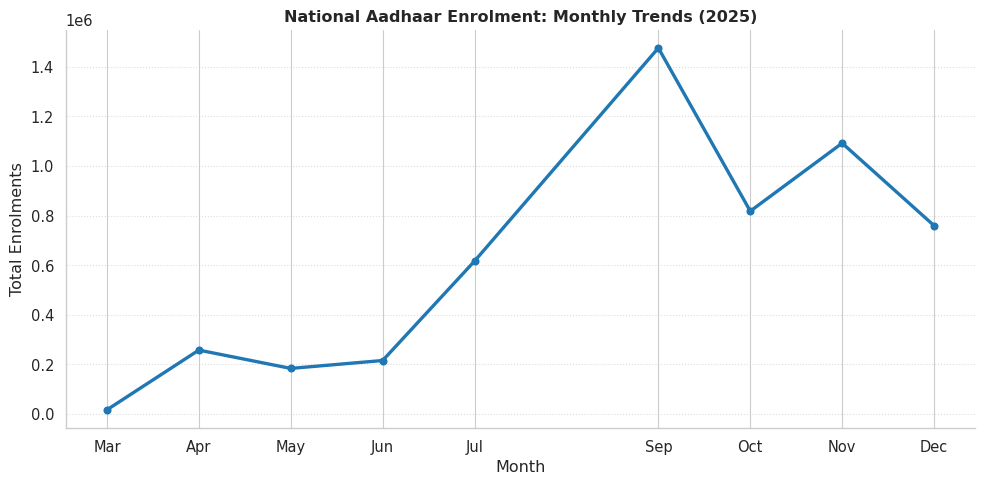

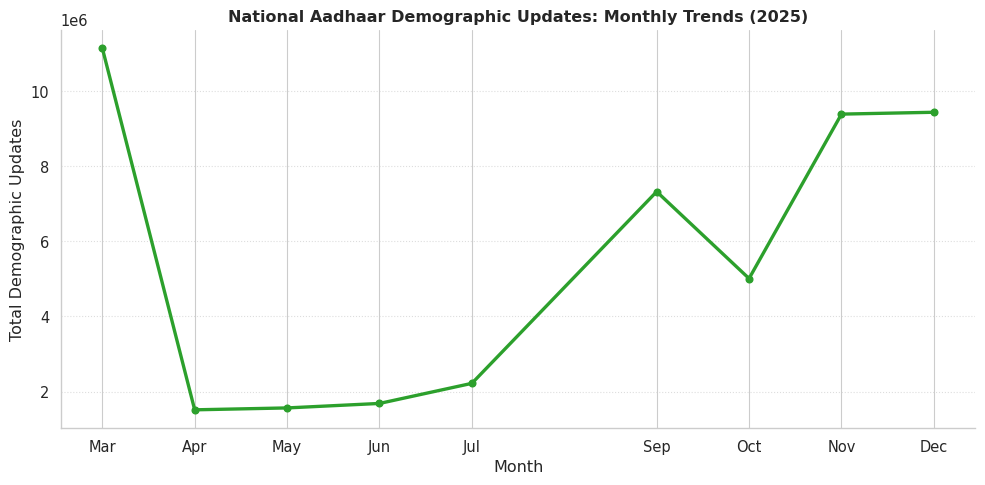

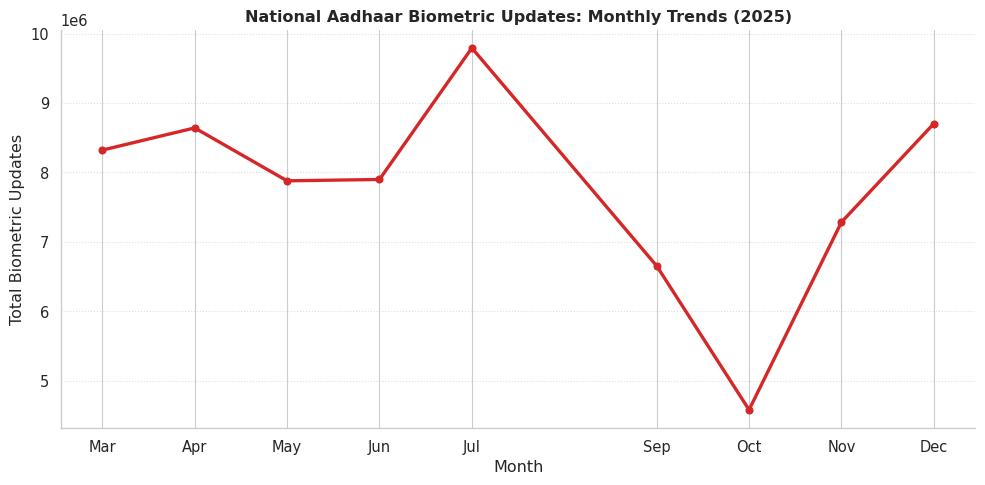

In [33]:
sns.set_theme(
    style="whitegrid",
    context="paper",
    font_scale=1.2
)

def plot_national_monthly_trend(
    df,
    value_col,
    title,
    y_label,
    color
):
    monthly = (
        df
        .groupby(['year','month','month_name'], as_index=False)
        .agg({value_col: 'sum'})
        .sort_values(['year','month'])
    )

    plt.figure(figsize=(10, 5))
    ax = plt.gca()

    ax.plot(
        monthly['month'],
        monthly[value_col],
        marker='o',
        linewidth=2.4,
        color=color
    )

    ax.set_xticks(monthly['month'])
    ax.set_xticklabels(monthly['month_name'])

    ax.set_xlabel('Month')
    ax.set_ylabel(y_label)

    ax.set_title(title, fontweight='bold')

    ax.ticklabel_format(style='sci', axis='y', scilimits=(6, 6))
    ax.grid(axis='y', linestyle=':', alpha=0.65)

    sns.despine(top=True, right=True)
    plt.tight_layout()
    plt.show()

plot_national_monthly_trend(
    df_enrol,
    value_col='total_enrol',
    title='National Aadhaar Enrolment: Monthly Trends (2025)',
    y_label='Total Enrolments',
    color='#1f77b4'
)

plot_national_monthly_trend(
    df_demo,
    value_col='total_demo',
    title='National Aadhaar Demographic Updates: Monthly Trends (2025)',
    y_label='Total Demographic Updates',
    color='#2ca02c'
)

plot_national_monthly_trend(
    df_bio,
    value_col='total_bio',
    title='National Aadhaar Biometric Updates: Monthly Trends (2025)',
    y_label='Total Biometric Updates',
    color='#d62728'
)


# Cross-Dataset Monthly Comparison

Aligned Monthly Comparison (Same Axis)

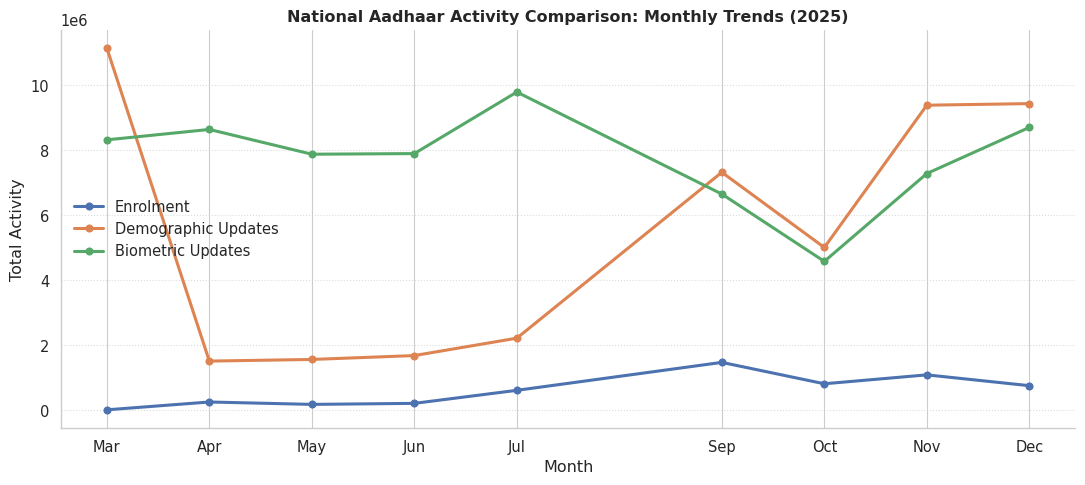

In [34]:
monthly_enrol = (
    df_enrol
    .groupby(['year','month','month_name'], as_index=False)
    .agg(total_enrol=('total_enrol','sum'))
)

monthly_demo = (
    df_demo
    .groupby(['year','month','month_name'], as_index=False)
    .agg(total_demo=('total_demo','sum'))
)

monthly_bio = (
    df_bio
    .groupby(['year','month','month_name'], as_index=False)
    .agg(total_bio=('total_bio','sum'))
)


plt.figure(figsize=(11, 5))
ax = plt.gca()

ax.plot(
    monthly_enrol['month'],
    monthly_enrol['total_enrol'],
    marker='o',
    linewidth=2.2,
    label='Enrolment'
)

ax.plot(
    monthly_demo['month'],
    monthly_demo['total_demo'],
    marker='o',
    linewidth=2.2,
    label='Demographic Updates'
)

ax.plot(
    monthly_bio['month'],
    monthly_bio['total_bio'],
    marker='o',
    linewidth=2.2,
    label='Biometric Updates'
)

ax.set_xticks(monthly_enrol['month'])
ax.set_xticklabels(monthly_enrol['month_name'])

ax.set_xlabel('Month')
ax.set_ylabel('Total Activity')
ax.set_title(
    'National Aadhaar Activity Comparison: Monthly Trends (2025)',
    fontweight='bold'
)

ax.ticklabel_format(style='sci', axis='y', scilimits=(6,6))
ax.legend(frameon=False)
ax.grid(axis='y', linestyle=':', alpha=0.7)

sns.despine(top=True, right=True)
plt.tight_layout()
plt.show()


# State-Level Distribution

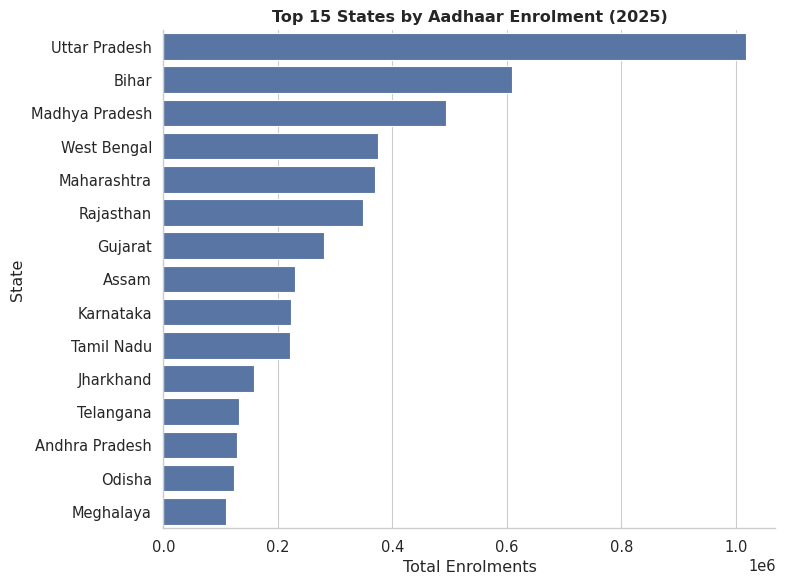

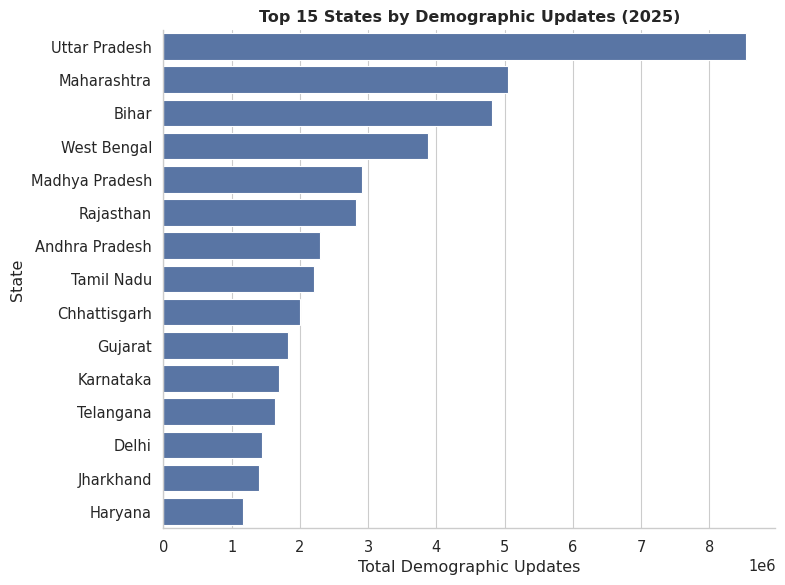

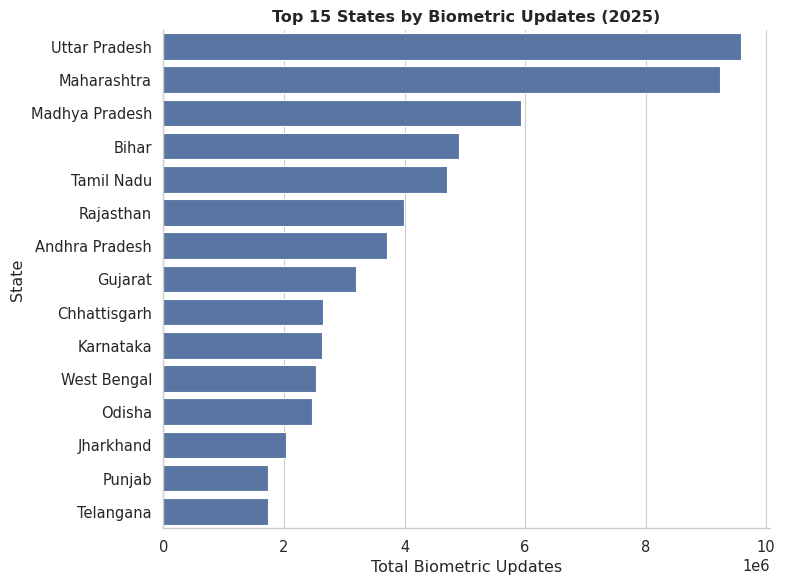

In [35]:
def plot_top_states(df, value_col, title, xlabel):
    top_states = (
        df.groupby('state_clean', as_index=False)
        .agg(total=(value_col, 'sum'))
        .sort_values('total', ascending=False)
        .head(15)
    )

    plt.figure(figsize=(8, 6))
    sns.barplot(
        data=top_states,
        x='total',
        y='state_clean'
    )

    plt.xlabel(xlabel)
    plt.ylabel('State')
    plt.title(title, fontweight='bold')
    plt.ticklabel_format(style='sci', axis='x', scilimits=(6,6))

    sns.despine()
    plt.tight_layout()
    plt.show()

plot_top_states(
    df_enrol,
    'total_enrol',
    'Top 15 States by Aadhaar Enrolment (2025)',
    'Total Enrolments'
)

plot_top_states(
    df_demo,
    'total_demo',
    'Top 15 States by Demographic Updates (2025)',
    'Total Demographic Updates'
)

plot_top_states(
    df_bio,
    'total_bio',
    'Top 15 States by Biometric Updates (2025)',
    'Total Biometric Updates'
)


To maintain interpretability and policy relevance. High-volume states drive national operational load, while lower-volume regions are better analyzed using normalized indicators rather than absolute counts.

# State-wise Normalized Ratio Comparison

Adult Demographic Update Ratio by State

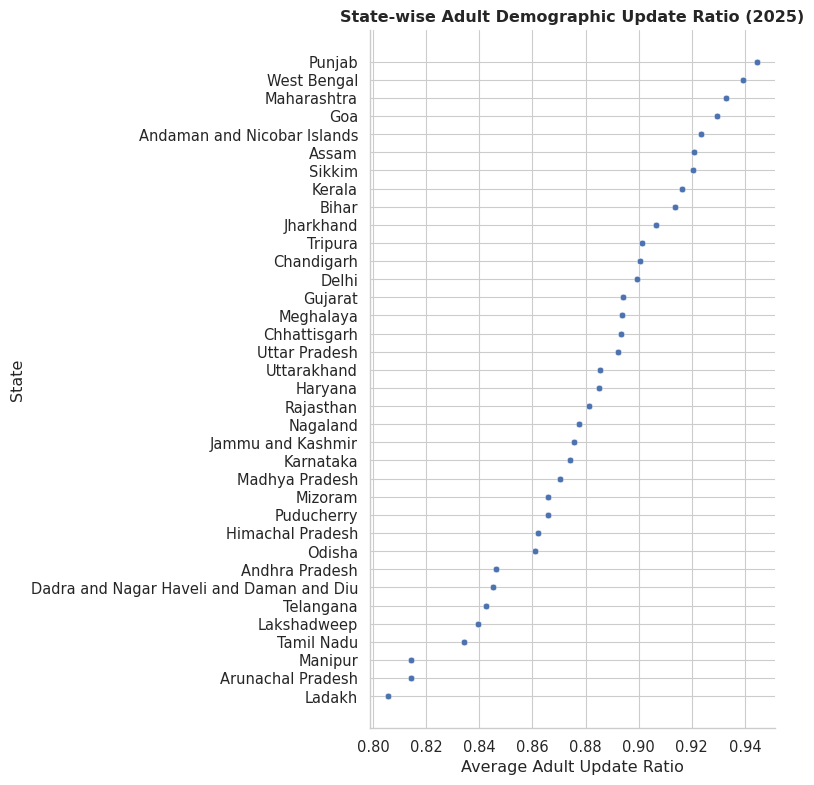

In [36]:
demo_ratio_state = (
    df_demo
    .groupby('state_clean', as_index=False)
    .agg(adult_demo_ratio=('adult_demo_ratio','mean'))
    .sort_values('adult_demo_ratio', ascending=False)
)

plt.figure(figsize=(8, 8))
sns.scatterplot(
    data=demo_ratio_state,
    x='adult_demo_ratio',
    y='state_clean'
)

plt.xlabel('Average Adult Update Ratio')
plt.ylabel('State')
plt.title(
    'State-wise Adult Demographic Update Ratio (2025)',
    fontweight='bold'
)

sns.despine()
plt.tight_layout()
plt.show()


Adult Biometric Update Ratio by State

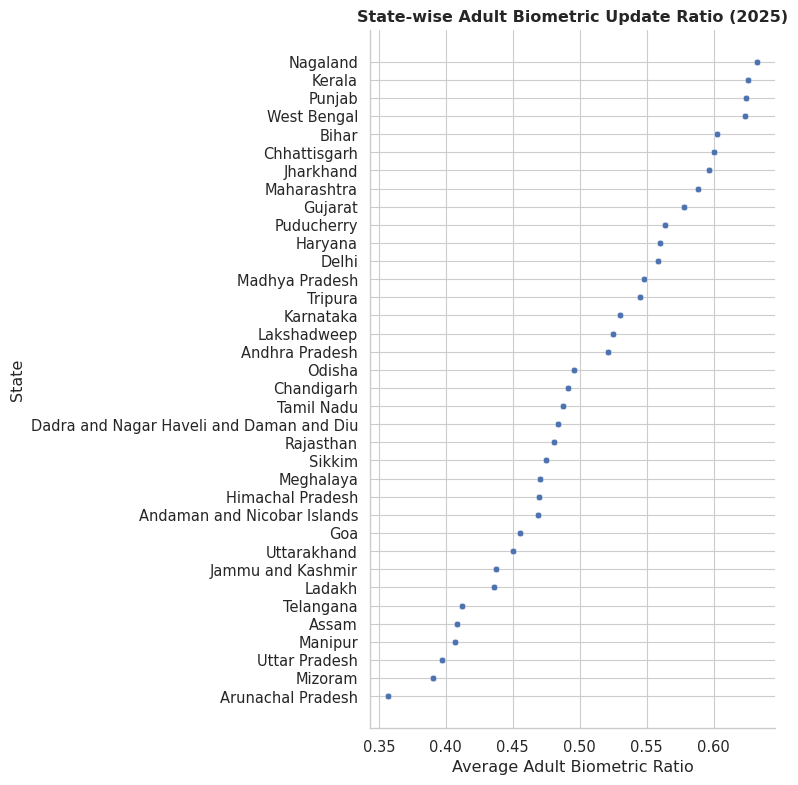

In [37]:
bio_ratio_state = (
    df_bio
    .groupby('state_clean', as_index=False)
    .agg(adult_bio_ratio=('adult_bio_ratio','mean'))
    .sort_values('adult_bio_ratio', ascending=False)
)


plt.figure(figsize=(8, 8))
sns.scatterplot(
    data=bio_ratio_state,
    x='adult_bio_ratio',
    y='state_clean'
)

plt.xlabel('Average Adult Biometric Ratio')
plt.ylabel('State')
plt.title(
    'State-wise Adult Biometric Update Ratio (2025)',
    fontweight='bold'
)

sns.despine()
plt.tight_layout()
plt.show()


# Month × State Heatmaps (Trivariate)

Heatmap — Demographic Updates

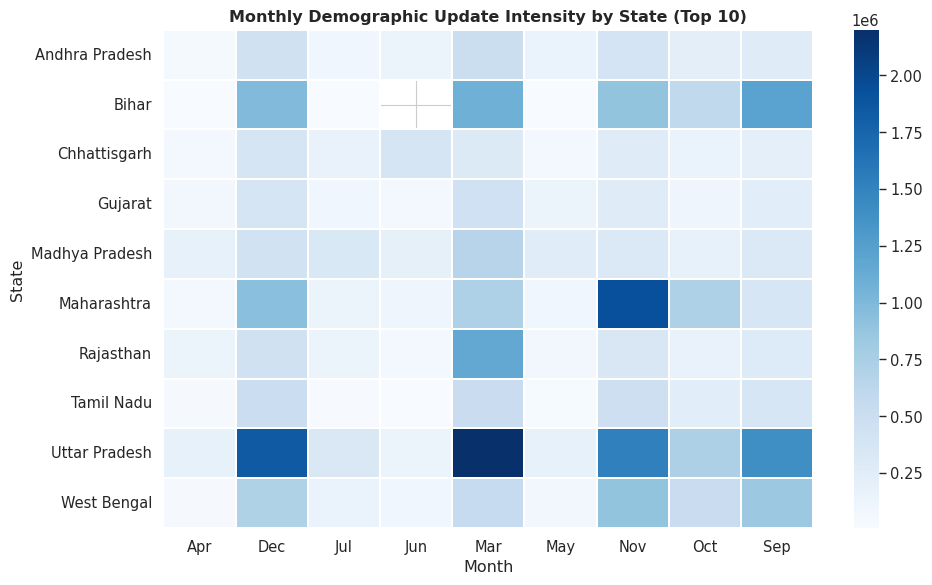

In [38]:
def get_top_states(df, value_col, n=10):
    return (
        df.groupby('state_clean')[value_col]
        .sum()
        .sort_values(ascending=False)
        .head(n)
        .index
    )


top_states_demo = get_top_states(df_demo, 'total_demo')

heat_demo = (
    df_demo[df_demo['state_clean'].isin(top_states_demo)]
    .groupby(['state_clean','month_name'], as_index=False)
    .agg(total_demo=('total_demo','sum'))
)

heat_demo_pivot = heat_demo.pivot(
    index='state_clean',
    columns='month_name',
    values='total_demo'
)

plt.figure(figsize=(10, 6))
sns.heatmap(
    heat_demo_pivot,
    cmap='Blues',
    linewidths=0.3
)

plt.title(
    'Monthly Demographic Update Intensity by State (Top 10)',
    fontweight='bold'
)

plt.xlabel('Month')
plt.ylabel('State')
plt.tight_layout()
plt.show()


Heatmap — Biometric Updates

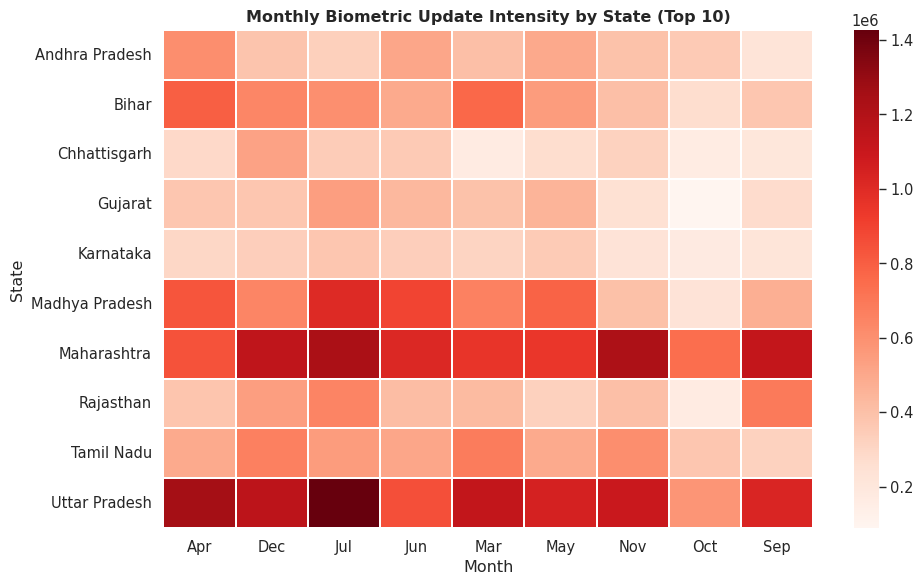

In [39]:
top_states_bio = get_top_states(df_bio, 'total_bio')

heat_bio = (
    df_bio[df_bio['state_clean'].isin(top_states_bio)]
    .groupby(['state_clean','month_name'], as_index=False)
    .agg(total_bio=('total_bio','sum'))
)

heat_bio_pivot = heat_bio.pivot(
    index='state_clean',
    columns='month_name',
    values='total_bio'
)

plt.figure(figsize=(10, 6))
sns.heatmap(
    heat_bio_pivot,
    cmap='Reds',
    linewidths=0.3
)

plt.title(
    'Monthly Biometric Update Intensity by State (Top 10)',
    fontweight='bold'
)

plt.xlabel('Month')
plt.ylabel('State')
plt.tight_layout()
plt.show()


The heatmap focuses on the highest-activity states to preserve interpretability and highlight operational stress patterns. Lower-volume states are analyzed using normalized indicators, ensuring they are not ignored but examined using more appropriate metrics.

# State-wise Demo vs Bio Ratio Comparison

In [40]:
state_demo_ratio = (
    df_demo
    .groupby('state_clean', as_index=False)
    .agg(demo_ratio=('adult_demo_ratio','mean'))
)

state_bio_ratio = (
    df_bio
    .groupby('state_clean', as_index=False)
    .agg(bio_ratio=('adult_bio_ratio','mean'))
)

state_ratio_compare = state_demo_ratio.merge(
    state_bio_ratio,
    on='state_clean',
    how='inner'
)

state_ratio_compare['deviation'] = (
    state_ratio_compare['demo_ratio'] -
    state_ratio_compare['bio_ratio']
).abs()

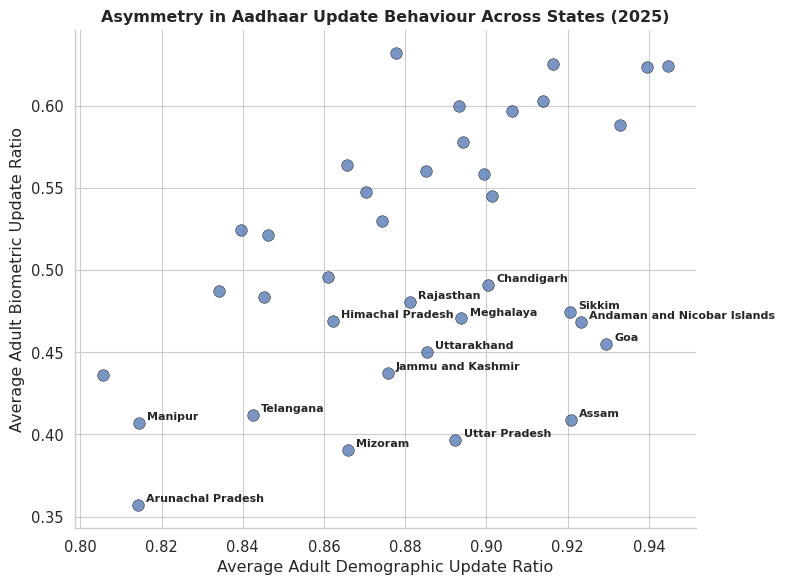

In [41]:
top_anomalies = (
    state_ratio_compare
    .sort_values('deviation', ascending=False)
    .head(15)
)

plt.figure(figsize=(8, 6))
ax = plt.gca()   

sns.scatterplot(
    data=state_ratio_compare,
    x='demo_ratio',
    y='bio_ratio',
    s=70,
    alpha=0.75,
    edgecolor='black',
    linewidth=0.4,
    ax=ax
)



# Annotate only top anomalies
for _, row in top_anomalies.iterrows():
    ax.text(
        row['demo_ratio'] + 0.002,
        row['bio_ratio'] + 0.002,
        row['state_clean'],
        fontsize=8,
        weight='bold'
    )



ax.set_xlabel('Average Adult Demographic Update Ratio')
ax.set_ylabel('Average Adult Biometric Update Ratio')
ax.set_title(
    'Asymmetry in Aadhaar Update Behaviour Across States (2025)',
    fontweight='bold'
)

sns.despine()
plt.tight_layout()
plt.show()


# District-Level Skew & Anomaly Detection

District-Level Distribution (Long-Tail Detection)

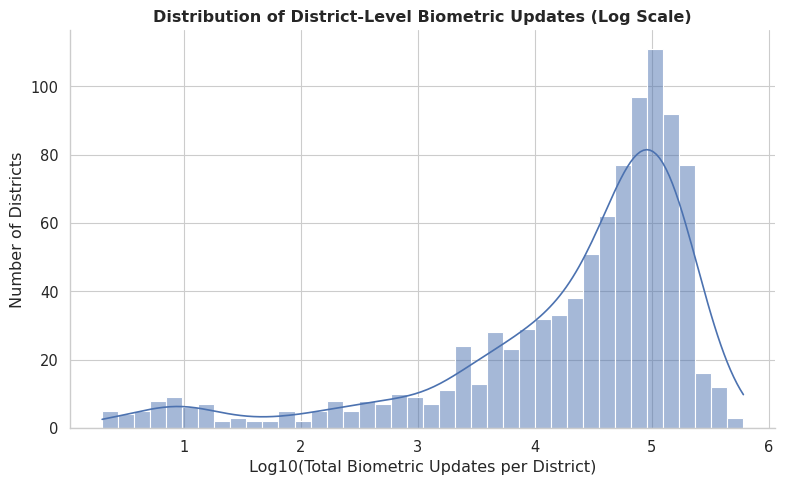

In [42]:
#Prepare district-level aggregates

district_enrol = (
    df_enrol
    .groupby(['state_clean','district_clean'], as_index=False)
    .agg(total_enrol=('total_enrol','sum'))
)

district_demo = (
    df_demo
    .groupby(['state_clean','district_clean'], as_index=False)
    .agg(total_demo=('total_demo','sum'))
)

district_bio = (
    df_bio
    .groupby(['state_clean','district_clean'], as_index=False)
    .agg(total_bio=('total_bio','sum'))
)

#Distribution plot (Log-scale)
plt.figure(figsize=(8, 5))

sns.histplot(
    np.log10(district_bio['total_bio'] + 1),
    bins=40,
    kde=True
)

plt.xlabel('Log10(Total Biometric Updates per District)')
plt.ylabel('Number of Districts')
plt.title(
    'Distribution of District-Level Biometric Updates (Log Scale)',
    fontweight='bold'
)

sns.despine()
plt.tight_layout()
plt.show()


Outlier Identification

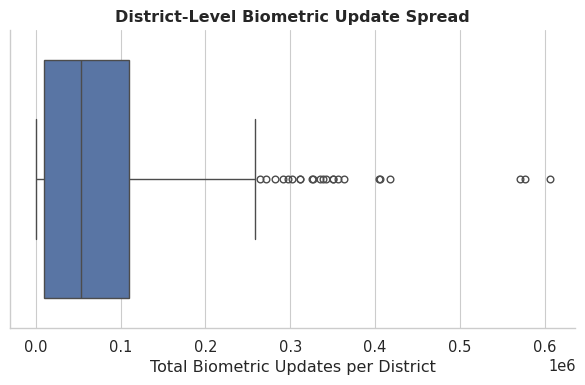

In [43]:
#Identify extreme districts using IQR method

Q1 = district_bio['total_bio'].quantile(0.25)
Q3 = district_bio['total_bio'].quantile(0.75)
IQR = Q3 - Q1

upper_bound = Q3 + 1.5 * IQR
lower_bound = Q1 - 1.5 * IQR

outliers_bio = district_bio[
    (district_bio['total_bio'] > upper_bound) |
    (district_bio['total_bio'] < lower_bound)
]

#boxplot

plt.figure(figsize=(6, 4))

sns.boxplot(
    x=district_bio['total_bio']
)

plt.xlabel('Total Biometric Updates per District')
plt.title(
    'District-Level Biometric Update Spread',
    fontweight='bold'
)

plt.ticklabel_format(style='sci', axis='x', scilimits=(6,6))
sns.despine()
plt.tight_layout()
plt.show()


Ratio-Based District Outliers

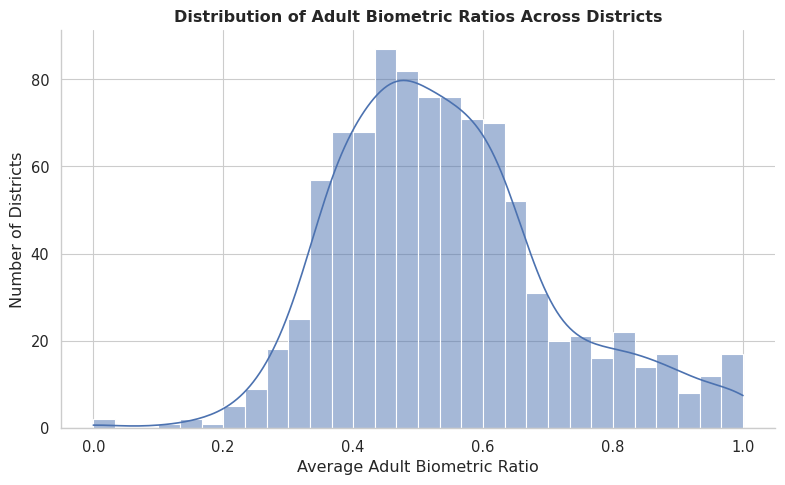

In [44]:
district_bio_ratio = (
    df_bio
    .groupby(['state_clean','district_clean'], as_index=False)
    .agg(mean_adult_ratio=('adult_bio_ratio','mean'))
)

plt.figure(figsize=(8, 5))
sns.histplot(
    district_bio_ratio['mean_adult_ratio'],
    bins=30,
    kde=True
)

plt.xlabel('Average Adult Biometric Ratio')
plt.ylabel('Number of Districts')
plt.title(
    'Distribution of Adult Biometric Ratios Across Districts',
    fontweight='bold'
)

sns.despine()
plt.tight_layout()
plt.show()


# State Clustering: Behavioural Archetypes

In [45]:
#prepare dataframe

state_cluster_df = (
    df_demo
    .groupby('state_clean')
    .agg(
        demo_ratio=('adult_demo_ratio', 'mean'),
        demo_volume=('total_demo', 'sum')
    )
    .merge(
        df_bio
        .groupby('state_clean')
        .agg(
            bio_ratio=('adult_bio_ratio', 'mean'),
            bio_volume=('total_bio', 'sum')
        ),
        on='state_clean',
        how='inner'
    )
)

# Normalize volumes (log-scale to reduce dominance)
state_cluster_df['demo_volume_norm'] = np.log1p(state_cluster_df['demo_volume'])
state_cluster_df['bio_volume_norm'] = np.log1p(state_cluster_df['bio_volume'])

#feature matrix and scaling

from sklearn.preprocessing import StandardScaler

features = [
    'demo_ratio',
    'bio_ratio',
    'demo_volume_norm',
    'bio_volume_norm'
]

X = state_cluster_df[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

from sklearn.cluster import KMeans

kmeans = KMeans(
    n_clusters=4,
    random_state=42,
    n_init=20
)

state_cluster_df['cluster'] = kmeans.fit_predict(X_scaled)

cluster_summary = (
    state_cluster_df
    .groupby('cluster')
    .mean()[features]
    .round(3)
)

cluster_summary


,demo_ratio,bio_ratio,demo_volume_norm,bio_volume_norm
cluster,,,,
0,0.870,0.470,14.102,14.587
1,0.902,0.513,10.591,11.131
2,0.913,0.596,14.443,14.752
3,0.831,0.433,9.804,10.514


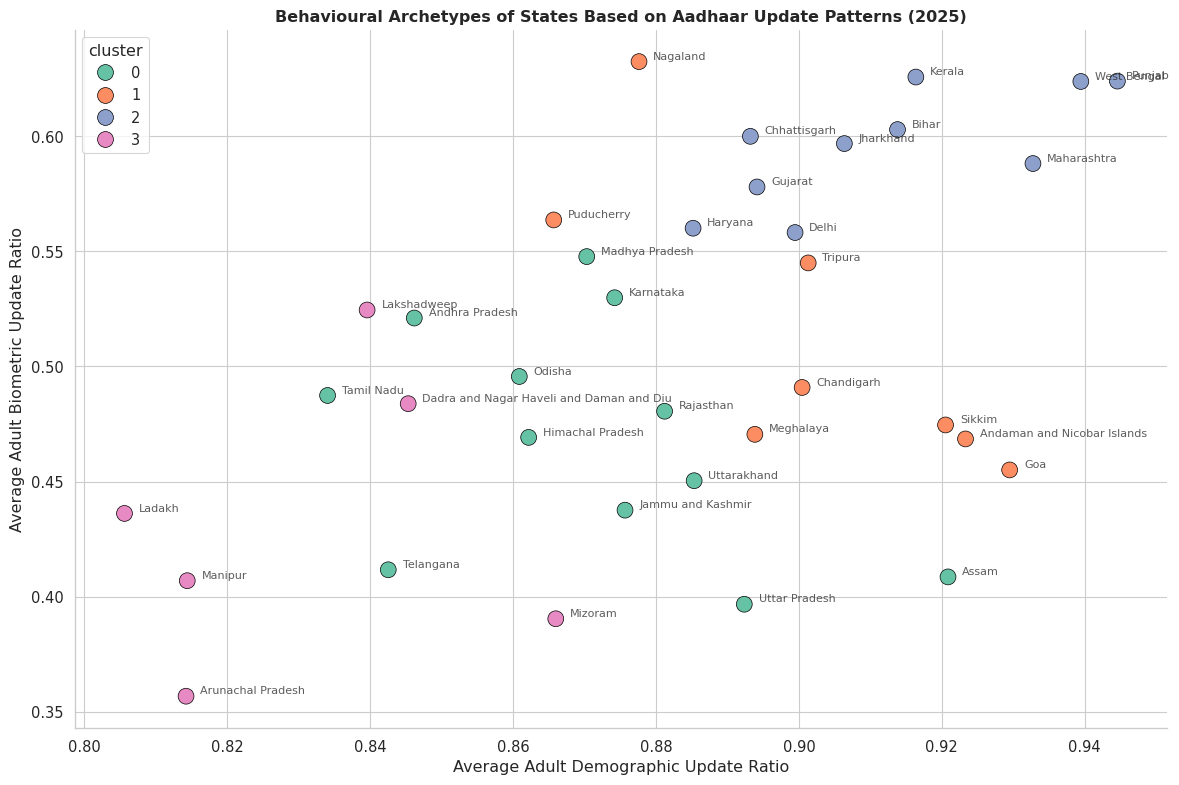

In [54]:
plt.figure(figsize=(12, 8))

sns.scatterplot(
    data=state_cluster_df,
    x='demo_ratio',
    y='bio_ratio',
    hue='cluster',
    palette='Set2',
    s=130,
    edgecolor='black',
    linewidth=0.5
)

for _, row in state_cluster_df.iterrows():
    plt.text(
        row['demo_ratio'] + 0.002,
        row['bio_ratio'] + 0.001,
        row.name,
        fontsize=8,
        alpha=0.75
    )

plt.xlabel('Average Adult Demographic Update Ratio')
plt.ylabel('Average Adult Biometric Update Ratio')
plt.title(
    'Behavioural Archetypes of States Based on Aadhaar Update Patterns (2025)',
    fontweight='bold'
)

sns.despine()
plt.tight_layout()
plt.show()


States were grouped into four behavioural archetypes based on normalized Aadhaar demographic and biometric update patterns. The clusters reveal structurally distinct interaction modes with the Aadhaar ecosystem—ranging from high-intensity, infrastructure-heavy states to low-engagement regions requiring targeted outreach. These archetypes enable differentiated administrative strategies rather than uniform policy deployment.

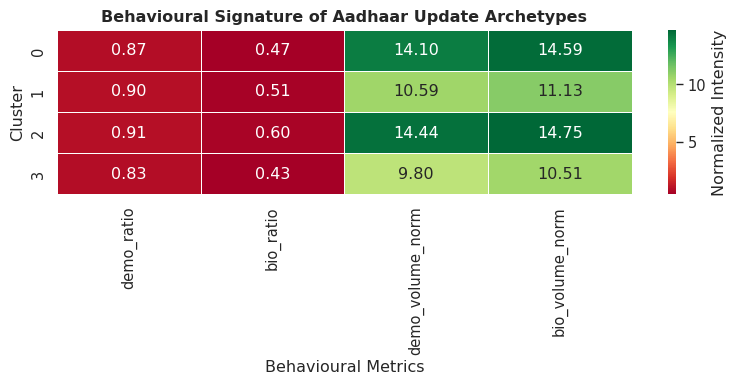

In [55]:
#cluster heatmap

cluster_heatmap = cluster_summary.copy()

plt.figure(figsize=(8, 4))
sns.heatmap(
    cluster_heatmap,
    annot=True,
    cmap="RdYlGn",
    fmt=".2f",
    linewidths=0.6,
    cbar_kws={'label': 'Normalized Intensity'}
)

plt.title(
    "Behavioural Signature of Aadhaar Update Archetypes",
    fontweight="bold"
)
plt.ylabel("Cluster")
plt.xlabel("Behavioural Metrics")

plt.tight_layout()
plt.show()

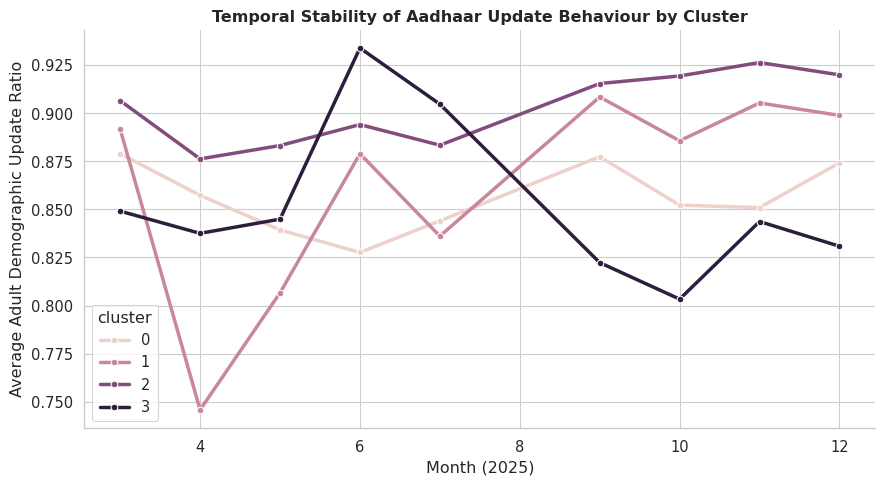

In [ ]:
#state trajectory plot

cluster_monthly = (
    df_demo
    .merge(state_cluster_df[['cluster']], on='state_clean')
    .groupby(['cluster', 'month'])
    .adult_demo_ratio
    .mean()
    .reset_index()
)

plt.figure(figsize=(9,5))
sns.lineplot(
    data=cluster_monthly,
    x='month',
    y='adult_demo_ratio',
    hue='cluster',
    marker='o',
    linewidth=2.5
)

plt.xlabel("Month (2025)")
plt.ylabel("Average Adult Demographic Update Ratio")
plt.title(
    "Temporal Stability of Aadhaar Update Behaviour by Cluster",
    fontweight="bold"
)

sns.despine()
plt.tight_layout()
plt.show()


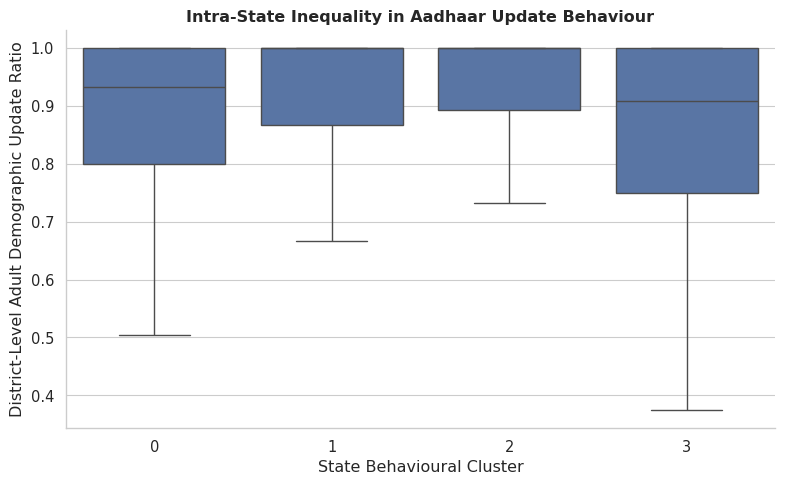

In [57]:
#district skew distribution

district_cluster = (
    df_demo
    .merge(state_cluster_df[['cluster']], on='state_clean')
)

plt.figure(figsize=(8,5))
sns.boxplot(
    data=district_cluster,
    x='cluster',
    y='adult_demo_ratio',
    showfliers=False
)

plt.xlabel("State Behavioural Cluster")
plt.ylabel("District-Level Adult Demographic Update Ratio")
plt.title(
    "Intra-State Inequality in Aadhaar Update Behaviour",
    fontweight="bold"
)

sns.despine()
plt.tight_layout()
plt.show()


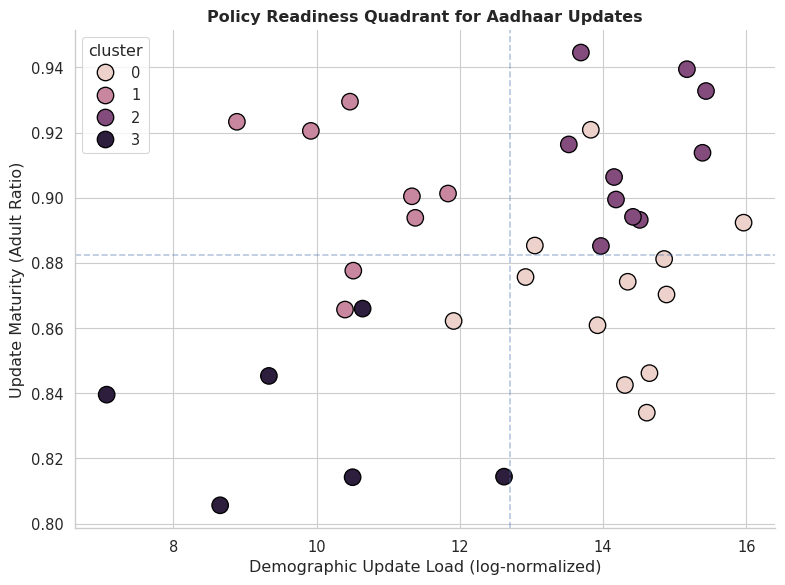

In [58]:
#policy readiness

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=state_cluster_df,
    x='demo_volume_norm',
    y='demo_ratio',
    hue='cluster',
    s=140,
    edgecolor='black'
)

plt.axhline(state_cluster_df['demo_ratio'].mean(), ls='--', alpha=0.4)
plt.axvline(state_cluster_df['demo_volume_norm'].mean(), ls='--', alpha=0.4)

plt.xlabel("Demographic Update Load (log-normalized)")
plt.ylabel("Update Maturity (Adult Ratio)")
plt.title(
    "Policy Readiness Quadrant for Aadhaar Updates",
    fontweight="bold"
)

sns.despine()
plt.tight_layout()
plt.show()
